In [5]:
from unet import *
import functions
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pandas as pd
import scipy.io
# tensor summary import
from torchsummary import summary

In [6]:
checkpoint = "checkpoints_private/2023_03_30.pt"
Net = build_unet()
Net.load_state_dict(torch.load(checkpoint))
Net.eval()
# check if CUDA is available, and set it as the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==> Device: {}".format(device))

# move model to the device
Net.to(device)

# define loss function
#loss_function = nn.MSELoss()
loss_function = nn.L1Loss()

####### HYPERPARAMETERS #######

# patch size
patch_size = 512

# batch size
batch_size = 1

# keep track of the best validation loss
valid_loss_min = np.Inf

##### LOSS  #######

# keep track of training and validation loss
test_loss = []
valid_loss = []

# initialize the early_stopping object
# early_stopping = EarlyStopping(patience=early_stopping, verbose=True)


==> Device: cuda


In [7]:
# read the list.txt as a space separated dataframe
df = pd.read_csv('list_shortkingdom.csv', sep=',', header=None)
#df = pd.read_csv('list_test.csv', sep=',', header=None)

# split df into input, label columns
input_df = df.iloc[:, 0]
label_df = df.iloc[:, 1]

# create a list of tuples
image_label_list = list(zip(input_df, label_df))

# create a dataset object
dataset = Dataset()

# create a dataloader object
dataloader = DataLoader(image_label_list, batch_size=batch_size, shuffle=False)

print('number of images in dataset: {}'.format(len(dataloader)))

result_dir = "results_test/"
if not os.path.isdir(result_dir):
                os.makedirs(result_dir)

number of images in dataset: 37


 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_00_0.04s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_00_0.1s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_01_0.04s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_01_0.1s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_02_0.1s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/Sony/short/00001_03_0.1s.ARW',)
Label: ('images/SonyImages/Sony/long/00001_00_10s.ARW',)
 ------------ new batch --------------
Input: ('images/SonyImages/So

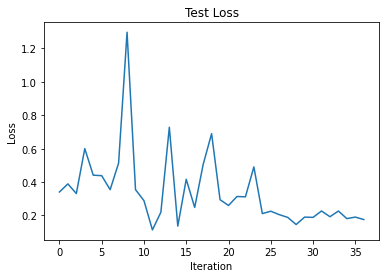

In [8]:
epoch_loss = 0
cnt = 0

for input, label in dataloader:
    # load the first image and label
    print(' ------------ new batch --------------')
    print("Input: " + str(input))
    print("Label: " + str(label))

    ratio = min(10.0 / 0.1, 300)

    input = input[0]
    label = label[0]

    #image = rawpy.imread(input)
    image = functions.pack_raw_sony(rawpy.imread(input)) * ratio
    #image = np.expand_dims(image, axis=0)
    label = rawpy.imread(label)

    # convert the image and label to numpy arrays
    #image = image.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
    label = label.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

    # convert the image and label to float32 data type
    #image = np.float32(image / 65535.0)
    label = np.float32(label / 65535.0)
    #label = np.expand_dims(label, axis=0)

    # strip input and label from paranthese
    # if cnt % 20 == 0:
    #     # display the image and label
    #     # print("Input:")
    #     # plt.imshow(image)
    #     # plt.show()
    #     print("Label:")
    #     plt.imshow(label)
    #     plt.show()


    ####### POSTPROCESSING #######

    # crop the image and label to 512 x 512
    image, label = functions.random_crop(image, label, patch_size)

    # if cnt % 20 == 0:
    #     # display the image and label
    #     # print("Input patch:")
    #     # plt.imshow(image)
    #     # plt.show()
    #     print("Label patch:")
    #     plt.imshow(label)
    #     plt.show()

    # convert the image and label to tensors
    image = torch.from_numpy(np.expand_dims(np.transpose(image, (2, 0, 1)), axis=0))
    label = torch.from_numpy(np.expand_dims(np.transpose(label, (2, 0, 1)), axis=0))

    # move the image and label to the device
    image, label = image.to(device), label.to(device)

    # forward pass
    output = Net(image)

    # calculate the loss
    loss = loss_function(output, label)

    # # also display the input patch
    # # print("Label:")
    label_image = label[0].cpu().detach().numpy().transpose(1, 2, 0)
    # # plt.imshow(label_image)
    # # plt.show()
    # print("Output:")
    output_image = output[0].cpu().detach().numpy().transpose(1, 2, 0)
    output_image = np.minimum(np.maximum(output_image, 0), 1)
    output_image = np.concatenate((label_image, output_image), axis=1)
    # #output_image[:, :, [0, 1]] = output_image[:, :, [1, 0]]
    # plt.imshow(output_image)
    # plt.show()
    # print(f"Loss: {loss.item()}")

    functions.toimage(output_image * 255, high=255, low=0, cmin=0, cmax=255).save(
        result_dir + '%05d_' % ratio + str(os.path.basename(input)[:-3]) + 'jpg')

    # append loss to the list
    test_loss.append(loss.item())

    cnt = cnt + 1


# plot loss
plt.plot(test_loss)
plt.title("Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

# plot